1. Pasar de .FR a .npy en un dia
2. Regiones para tomar las imagenes y tamaños que quedan cada una
3. Como cargamos las imagenes a memoria
4. Persistencia, persistencia borrosa, cmv
5. Visualizacion de las imagenes, ventana que saca nans, predicciones, ventana sin nans
6. Evaluacion de las predicciones
7. Dataset, outliers, tamaño del dataset restante, etc

In [1]:
from src.data import save_imgs_list_2npy
import os
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

from torch.utils.data import DataLoader

from src import data, evaluate, model, preprocessing, visualization
from src.lib import utils

plt.rcParams['figure.figsize'] = [8, 5]

# 1. Pasar de .FT a .npy de un dia

In [4]:
df_dataset = pd.read_csv("reports/dataset_2020.csv")
imgs_list_day1 = []

M = len(df_dataset.values[0][2])  
str_list = df_dataset.values[0][2][1:M-1].replace('\'',"" )
str_list = str_list.replace(" ", "")
imgs_list_day1 = str_list.split(",")
    

path = '/solar/sat/art-rrr/ART_G010x010RR_C010x010/' 
to_fr = 'C02-FR/2020/'
to_mk = 'C02-MK/2020/'
to_meta = 'meta/'

save_imgs_list_2npy(
    imgs_list=imgs_list_day1,
    meta_path= os.path.join(path, to_meta),
    mk_folder_path= os.path.join(path, to_mk),
    img_folder_path= os.path.join(path, to_fr),
    destintation_path='data/images'
)

# 2. Regiones para tomar las imagenes y tamaños que quedan cada una

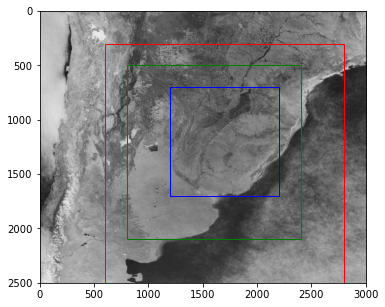

In [22]:
bkg = cv.imread('misc/bkg.png')

fig, ax = plt.subplots()

rect1 = patches.Rectangle((1200, 700), 1000, 1000, linewidth=1, edgecolor='b', facecolor='none') # xy, w, h
ax.add_patch(rect1)
rect2 = patches.Rectangle((800, 500), 1600, 1600, linewidth=1, edgecolor='g', facecolor='none')
ax.add_patch(rect2)
rect2 = patches.Rectangle((600, 300), 2200, 2200, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect2)

ax.imshow(bkg)


# 3. Como cargamos las imagenes a memoria

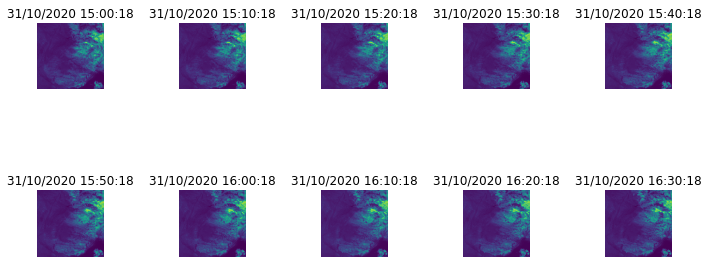

In [2]:
dataset_sw = data.SatelliteImagesDatasetSW(root_dir = 'data/images/dia_305', 
                                           window = 10,
                                           transform = preprocessing.CropImage(3))

dataset_sw[0].keys()

dl_sw = DataLoader(dataset_sw, batch_size=1, collate_fn=data.collate_fn_sw)

for idx, samples in enumerate(dl_sw):
    if idx == 90:
        visualization.show_sample_dict(samples , 2)
        break

In [3]:
start = time.time()
for samples in dl_sw:
    pass
end = time.time()

print('Going through the images of one day with a sliding window of 10 images takes: ', end - start, ' seconds.')

Going through the images of one day with a sliding window of 10 images takes:  9.025388240814209  seconds.


# 4. Persistencia, persistencia borrosa, cmv

In [8]:
def main_test(model_instance,dl_sw):
    predict_horizon = 10
    error_list =[]
    error_list_day = []

    per_predict_time= []
    eval_time = []
    cmv_predict_time = []
    
    for idx, samples in enumerate(dl_sw):

        if idx%50 == 0:
           print(idx)
        
        #predict depending on model
        if (isinstance(model_instance, model.Persistence)):
            start = time.time()
            predictions, prediction_ts = model_instance.predict(
                                    samples['images'][1], 
                                    samples['time_stamps'][1], 
                                    predict_horizon)
            end = time.time()
            per_predict_time.append(end-start)
            dynamic_window = False
        elif (isinstance(model_instance, model.Cmv)):
            start = time.time()
            predictions , cmv_ts = model_instance.predict(
                                    imgi=samples['images'][0, :, :], 
                                    imgf=samples['images'][1, :, :],
                                    imgf_ts = samples['time_stamps'][1], 
                                    period=10*60, delta_t=10*60, 
                                    predict_horizon=predict_horizon) 
            end = time.time()
            cmv_predict_time.append(end-start)
            dynamic_window = True

        #evaluate
        start = time.time()
        predict_errors = evaluate.evaluate_image(
                                                predictions = predictions, 
                                                gt = samples['images'][1:], 
                                                gt_ts = samples['time_stamps'][1:],
                                                metric='RMSE', dynamic_window=dynamic_window,
                                                evaluate_day_pixels = False)
        error_list.append(predict_errors)
        end = time.time()
        eval_time.append(end-start)
        predict_errors_day = evaluate.evaluate_image(
                                                predictions = predictions, 
                                                gt = samples['images'][1:], 
                                                gt_ts = samples['time_stamps'][1:],
                                                metric='RMSE', dynamic_window=dynamic_window,
                                                evaluate_day_pixels = True)
        error_list_day.append(predict_errors_day)
    print('persistence predict time: ', np.sum(per_predict_time))
    print('cmv predict time: ', np.sum(cmv_predict_time))
    print('evaluation time: ', np.sum(eval_time))
    return error_list , error_list_day

dataset_sw = data.SatelliteImagesDatasetSW(root_dir = 'data/images/dia_305', 
                                           window = predict_horizon+2,
                                           transform = preprocessing.CropImage(3))
dl_sw = DataLoader(dataset_sw, batch_size=1, collate_fn=data.collate_fn_sw)

cmv = model.Cmv2()
blurredCMV = model.Cmv2(kernel_size=(21,21))
persistence = model.Persistence()

print('Predicting CMV')
error_list_cmv, error_list_cmv_day = main_test(cmv,dl_sw)
print('Predicting Persistence')
error_list_p,error_list_p_day = main_test(persistence,dl_sw)
print('Predicting Blurred CMV') 
error_list_bp,error_list_bp_day = main_test(blurredCMV,dl_sw)

error_array_cmv = np.array(error_list_cmv)
error_array_p = np.array(error_list_p)
error_array_bp = np.array(error_list_bp)

error_array_cmv_day = np.array(error_list_cmv_day)
error_array_p_day = np.array(error_list_p_day)
error_array_bp_day = np.array(error_list_bp_day)

print('CMV predicted ', error_array_cmv.shape[1],  'images for' , error_array_cmv.shape[0], 'images')
print('Persistence predicted ', error_array_p.shape[1], 'images for' , error_array_p.shape[0],'images')
print('Blurred Persistence predicted ', error_array_bp.shape[1], 'images for' , error_array_bp.shape[0], 'images')

Predicting CMV
0


C:\Users\Usuario\anaconda3\lib\site-packages\skimage\metrics\simple_metrics.py:105: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(mean_squared_error(image_true, image_test)) / denom


50
100


C:\Users\Usuario\anaconda3\lib\site-packages\skimage\metrics\simple_metrics.py:105: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(mean_squared_error(image_true, image_test)) / denom


Predicting Persistence
0
50
100
Predicting Blurred CMV
0
50
100
CMV predicted  31 images for 113 images
Persistence predicted  31 images for 113 images
Blurred Persistence predicted  31 images for 113 images


# 5. Guardo matriz de error del dia en un .csv

In [10]:
df_dataset = pd.read_csv("reports/dataset_2020.csv")
imgs_list_day1 = []

M = len(df_dataset.values[0][2])  
str_list = df_dataset.values[0][2][1:M-1].replace('\'',"" )
str_list = str_list.replace(" ", "")
imgs_list_day1 = str_list.split(",")

utils.save_errorarray_as_csv(error_array_cmv, time_stamp=imgs_list_day1 ,filename =  "reports/cmv_error")

# 6. Graficas de errores

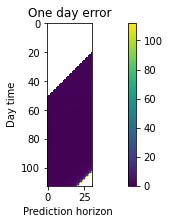

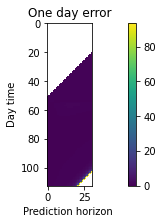

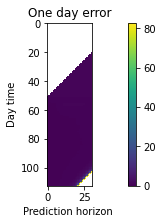

In [9]:
visualization.matrix_graph(error_array_cmv)
visualization.matrix_graph(error_array_p)
visualization.matrix_graph(error_array_bp)

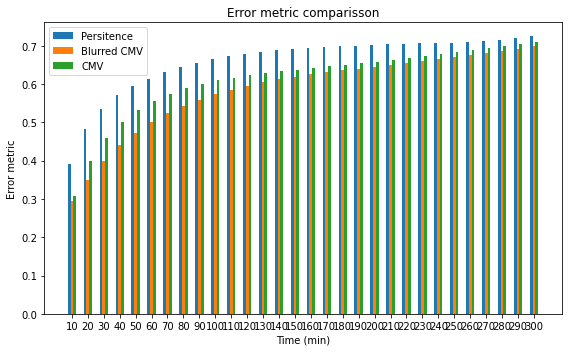

In [12]:
mean_error_cmv = np.mean(error_array_cmv,axis=0)
mean_error_p = np.mean(error_array_p,axis=0)
mean_error_bp = np.mean(error_array_bp,axis=0)

visualization.barchart_compare3(mean_error_p[1:], 'Persitence',
                 mean_error_bp[1:], 'Blurred CMV',
                 mean_error_cmv[1:], 'CMV')

mean_error_cmv_day = np.mean(error_array_cmv_day,axis=0)
mean_error_p_day = np.mean(error_array_p_day,axis=0)
mean_error_bp_day = np.mean(error_array_bp_day,axis=0)

visualization.barchart_compare3(mean_error_p_day[1:], 'Persitence',
                 mean_error_bp_day[1:], 'Blurred CMV',
                 mean_error_cmv_day[1:], 'CMV')

# 7. Visualizacion de las imagenes: ventana que saca nans, ventana sin nans


In [3]:
cmv2 = model.Cmv2()

predict_horizon = 30
dataset_sw = data.SatelliteImagesDatasetSW(root_dir = 'data/images/dia_1',
                                           window = 2,
                                           transform = preprocessing.CropImage(3))

samples = dataset_sw[100]

predictions = cmv2.predict(imgi=samples['images'][0], imgf=samples['images'][1], 
                period=10*60, delta_t=10*60, predict_horizon=predict_horizon) 


image = predictions[-1]
xmin, xmax, ymin, ymax = utils.find_inner_image(image)
fig, ax = plt.subplots()

rect = patches.Rectangle((ymin, xmin), len(image)-(ymin+ymax), len(image)-(xmin+xmax), linewidth=1, edgecolor='r', facecolor='none')

plt.imshow(image)
ax.add_patch(rect)
plt.show()

visualization.show_image_w_colorbar(image [xmin:len(image)-xmax, ymin:len(image)-ymax] )

KeyboardInterrupt: 

In [ ]:
start = time.time()
cosangs, cosangs_thresh = utils.get_cosangs_mask(meta_path='data/meta',
                    img_name='ART_2020020_111017.FR'
    )
end = time.time()
print(end - start)

visualization.show_image_w_colorbar (cosangs)
visualization.show_image_w_colorbar (cosangs_thresh)